Stress Test: How Did Regimes Behave During Crashes?

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

nifty = pd.read_csv("../data/nifty_strategy.csv", index_col=0, parse_dates=True)

nifty.head()

,price,log_return,volatility_20d,mean_return_20d,ma_50,price_ma_ratio,regime,regime_label,baseline_return,regime_strategy_return,baseline_equity,regime_equity
Date,,,,,,,,,,,,
2010-04-19,5203.649902,-0.011265,0.007627,-0.000271,5086.877012,1.022956,2,Bull / Risk-On,-0.011265,-0.011265,0.988735,0.988735
2010-04-20,5230.100098,0.005070,0.007695,-0.000151,5094.877012,1.026541,2,Bull / Risk-On,0.005070,0.005070,0.993748,0.993748
2010-04-21,5244.899902,0.002826,0.007686,-0.000170,5101.138008,1.028182,2,Bull / Risk-On,0.002826,0.002826,0.996556,0.996556
2010-04-22,5269.350098,0.004651,0.007313,0.000612,5109.618008,1.031261,2,Bull / Risk-On,0.004651,0.004651,1.001191,1.001191
2010-04-23,5304.100098,0.006573,0.007401,0.000748,5121.327012,1.035689,2,Bull / Risk-On,0.006573,0.006573,1.007772,1.007772


In [5]:
covid_period = nifty.loc["2020-02-01":"2020-06-30"]

covid_period['regime_label'].value_counts(normalize=True)


regime_label
Stress / Risk-Off     0.757576
Sideways / Neutral    0.232323
Bull / Risk-On        0.010101
Name: proportion, dtype: float64

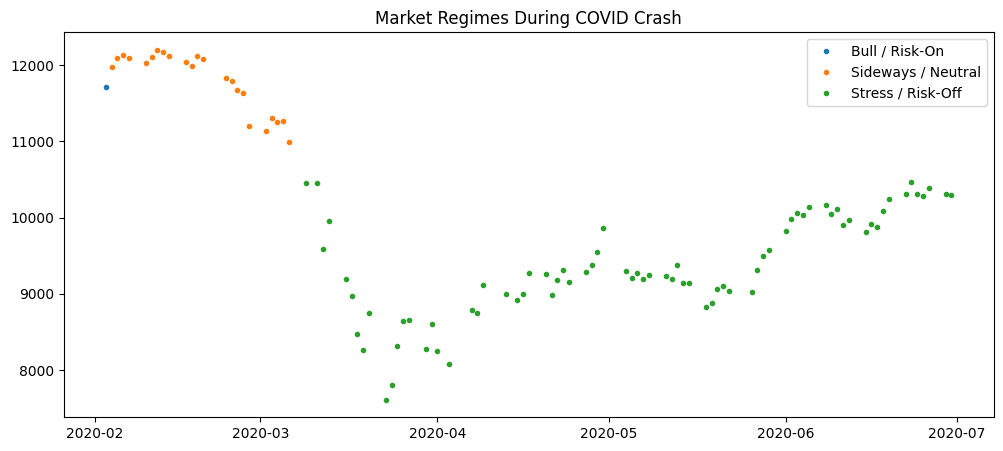

In [6]:
plt.figure(figsize=(12,5))

for label in covid_period['regime_label'].unique():
    mask = covid_period['regime_label'] == label
    plt.plot(
        covid_period.index[mask],
        covid_period['price'][mask],
        '.',
        label=label
    )

plt.title("Market Regimes During COVID Crash")
plt.legend()
plt.show()


Out-of-sample validation

In [9]:
split_date = "2018-01-01"

train = nifty.loc[nifty.index < split_date].copy()
test = nifty.loc[nifty.index >= split_date].copy()



In [11]:
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

features_cols = ['mean_return_20d', 'volatility_20d', 'price_ma_ratio']

scaler = StandardScaler()
X_train = scaler.fit_transform(train[features_cols])
X_test = scaler.transform(test[features_cols])

hmm_oos = GaussianHMM(
    n_components=3,
    covariance_type="full",
    n_iter=1000,
    random_state=42
)

hmm_oos.fit(X_train)

test['regime_oos'] = hmm_oos.predict(X_test)


Strategy Test


In [12]:
regime_labels = {
    0: "Stress / Risk-Off",
    1: "Sideways / Neutral",
    2: "Bull / Risk-On"
}

test['regime_label_oos'] = test['regime_oos'].map(regime_labels)

test['regime_strategy_return_oos'] = 0.0
mask = test['regime_label_oos'].isin(["Bull / Risk-On", "Sideways / Neutral"])
test.loc[mask, 'regime_strategy_return_oos'] = test.loc[mask, 'log_return']

test['baseline_equity_oos'] = (1 + test['log_return']).cumprod()
test['regime_equity_oos'] = (1 + test['regime_strategy_return_oos']).cumprod()


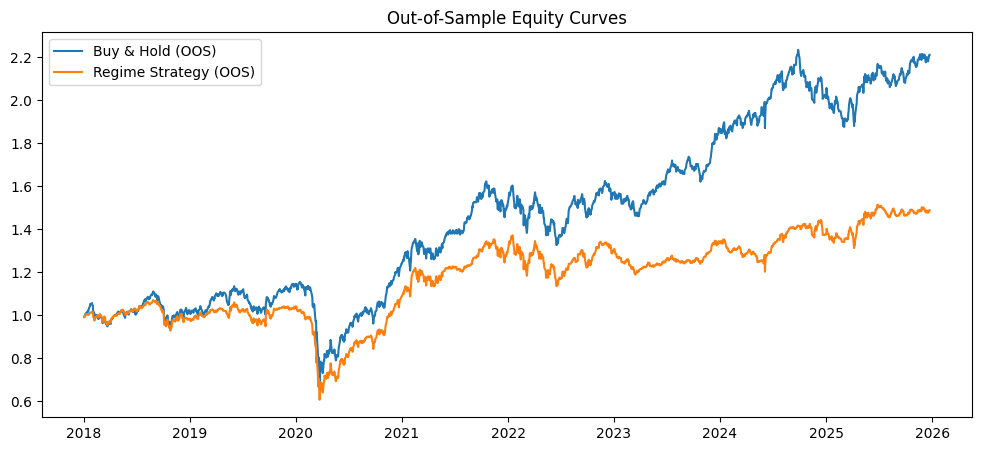

In [13]:
plt.figure(figsize=(12,5))
plt.plot(test.index, test['baseline_equity_oos'], label="Buy & Hold (OOS)")
plt.plot(test.index, test['regime_equity_oos'], label="Regime Strategy (OOS)")
plt.legend()
plt.title("Out-of-Sample Equity Curves")
plt.show()
